# Relax Inc Takehome Challenge

### Summary of Findings

**Basic Stats**

+ Total User Visits: 207,917
+ Unique Users that Visited: 8,823
+ Unique User Accounts: 12,000
+ Period of Data: May 2012 - May 2014

**Exploratory Analysis Findings**

+ Most commn signup types are by org invitation and guest invitation.
+ Majority of users not on marketing emails or marketing drip. 11% of users are in both. 
+ The number of adopted users is 1322 of 8823 total. Adopted users are: 15% of total users.

**Data Wrangling**

+ Missing values were filled with np.nan's
+ Time features were converted to timestamp format.

**Feature Creation**

Three new features were created: 

1. Drip List: This variable indicates whether the user is in both the marketing emails and the marketing drip.
2. Time Since Last Sesh: This variable quantifies in seconds how much time has passed since account creation to last session.
3. Adoped User: This variable indicates whether the user is consider adopted. as a user who has logged into the product on three separate days in at least one sevenday period.

**Train, Test and Validation Splits**

The task is to identify the factors that predict future user adoption. Below is the modeling procedure steps. 

1. X and Y arrays were created. I attempted to include time since last session on the x arrays, but the results were sub-optimal in the modeling phase so I did not used it.  

2. Train (85%), test(5%) and validation(10%) samples were created.

**Modeling Approach**

1. Given that the outcome variable is binary (1= adopted, 0 = not adopted), I attempted two models: (1) logistic regression and (2) decision tree. 

2. The models will be evaluated based on accuracy. This is the extent the model predicts the outcome variable correctly.

3. Once these two models were constructed, choose the model with the best accuracy. 

4. The logistic regression performed better than the decsion tree. The testing accuracy for the logistic regression was 83% and for the decision tree was 77%. Given the results, I continued to cross-validate and fine tune the parameters of the logistic regression. 

5. No signs of model overfitting were found. Using GridSearchCV, the best parameters for the logistic regression were C:0.00001 and regulariation L1. 

6. The final logistic regression model has testing accuracy of 83% and a cross validation accuracy of 84% (+/-) 0.16%.

**Modeling Findings**

+ Using relative feature importance it is clear that organization id by far the most important feature, followed by invited user id. The other features did not had much impact on the outcome. 
+ This suggests that users that were invited either through an organization or an individual were more likely to become adopted users.

**Recomendations and Next Steps**

What we know about the users is still limited and the results raise more questions. My recommendations are three fold. 

+ *First*, find more data about the organizations. Some of the questions that could be asked here are: Are individuals required to use the product?, Is it work related? Is it part of another offering? Does a point of contact on an organization matters?

+ *Second*, find more information about the individuals. How engaged are them in terms of marketing (example: email opened)? What are the factors that may lead someone to recommend the product? Who are they likely to recomend it to? How do they use the product?

+ *Third*, including data on timelogged. Is there an specific time spent using the product that leads to adoption?

### Import Libraries

In [1]:
#Data Exploration and Data Cleaning Libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
from datetime import datetime, timedelta

#Modeling Libraries

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, KFold

In [2]:
#Set Graphs style

rcParams['figure.figsize'] = 12, 12

rcParams['font.size'] = 12

sns.set(style='darkgrid')

sns.set_style({"xtick.major.size": 8, "ytick.major.size": 8})

sns.set_context("talk", font_scale=1.5)

### Upload User Account & Engagement Data to Pandas DataFrames

*User Accounts*

In [3]:
#Upload User Account Info

date_cols = ['creation_time','last_session_creation_time']

cols = ['object_id','creation_time','creation_source','last_session_creation_time',
        'opted_in_to_mailing_list','enabled_for_marketing_drip','org_id',
        'invited_by_user_id'] #not uploading user's email and name


accounts = pd.read_csv('takehome_users.csv', 
                       usecols = cols,
                       encoding = 'latin-1',
                       parse_dates = date_cols,
                       infer_datetime_format = True,
                       keep_date_col = False)
accounts.head(10)

print(accounts.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 8 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null datetime64[ns]
creation_source               12000 non-null object
last_session_creation_time    12000 non-null object
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(4), object(2)
memory usage: 750.1+ KB
None


Missing values in 'invited_by_user_id' feature. However this makes sense, because not all users will be invited by another user. The 'last_session_creation_time' was not converted to datetime using read_csv. Moreover, there are missing values in the last session creation time feature. This will create issues in converting to datetime.

In [4]:
accounts['last_session_creation_time'] = pd.to_datetime(accounts['last_session_creation_time'],
                                                        unit='s',
                                                        errors='coerce')

In [5]:
accounts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 8 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null datetime64[ns]
creation_source               12000 non-null object
last_session_creation_time    8823 non-null datetime64[ns]
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: datetime64[ns](2), float64(1), int64(4), object(1)
memory usage: 750.1+ KB


More than 20% missing on last session creation time. 

In [6]:
accounts.head()

,object_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:00,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0
1,2,2013-11-15 03:45:00,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0
2,3,2013-03-19 23:14:00,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0
3,4,2013-05-21 08:09:00,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0
4,5,2013-01-17 10:14:00,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0


*User Engagement*

In [7]:
# Upload User Engagement

date_cols2  = ['time_stamp']

engagement = pd.read_csv('takehome_user_engagement.csv',
                         parse_dates = date_cols2,
                         infer_datetime_format = True,
                         keep_date_col = False)

engagement.head()

print(engagement.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null datetime64[ns]
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB
None


In [8]:
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


No missing values in user engagement data.

### Explorarory Analysis

In [9]:
accounts.describe()

,object_id,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
count,12000.00000,12000.000000,12000.000000,12000.000000,6417.000000
mean,6000.50000,0.249500,0.149333,141.884583,5962.957145
std,3464.24595,0.432742,0.356432,124.056723,3383.761968
min,1.00000,0.000000,0.000000,0.000000,3.000000
25%,3000.75000,0.000000,0.000000,29.000000,3058.000000
50%,6000.50000,0.000000,0.000000,108.000000,5954.000000
75%,9000.25000,0.000000,0.000000,238.250000,8817.000000
max,12000.00000,1.000000,1.000000,416.000000,11999.000000


In [10]:
engagement.describe()

,user_id,visited
count,207917.000000,207917.0
mean,5913.314197,1.0
std,3394.941674,0.0
min,1.000000,1.0
25%,3087.000000,1.0
50%,5682.000000,1.0
75%,8944.000000,1.0
max,12000.000000,1.0


In [11]:
print('Total User Visits:', engagement['visited'].sum())

print('Unique Users that Visited:', engagement['user_id'].nunique())

print('Unique User Accounts:', accounts['object_id'].nunique())

Total User Visits: 207917
Unique Users that Visited: 8823
Unique User Accounts: 12000


In [12]:
#Explore Date Ranges 

#Account creation_time

print('Account Creation Date Ranges: ', 'Min:', accounts['creation_time'].min(), 'Max: ',accounts['creation_time'].max())
#Last Session

print('Last Session: ', 'Min:', accounts['last_session_creation_time'].min(), 'Max: ',accounts['last_session_creation_time'].max())

#Visits Time Stamp

print('Visit Time Stamp: ', 'Min:', engagement['time_stamp'].min(), 'Max: ',engagement['time_stamp'].max())

Account Creation Date Ranges:  Min: 2012-05-31 00:43:00 Max:  2014-05-30 23:59:00
Last Session:  Min: 2012-05-31 08:20:06 Max:  2014-06-06 14:58:50
Visit Time Stamp:  Min: 2012-05-31 08:20:06 Max:  2014-06-06 14:58:50


In [13]:
#Create function to do bar count plots of categorical variables.

def count_plot(df = None, col_name = None,
                title = 'Title Here', xlabel = '', ylabel = 'count'):
    
    '''Create bar count plots of categorical variables. 
    
       Return counts in x,xxx,xxx format'''
    
    ax = df[col_name].value_counts().plot(kind="bar")
    
    ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
    
    sns.despine()
    
    plt.xticks(rotation = 50)
    
    plt.title(title)
    
    plt.xlabel(xlabel)
    
    plt.ylabel(ylabel)
    
    plt.show()

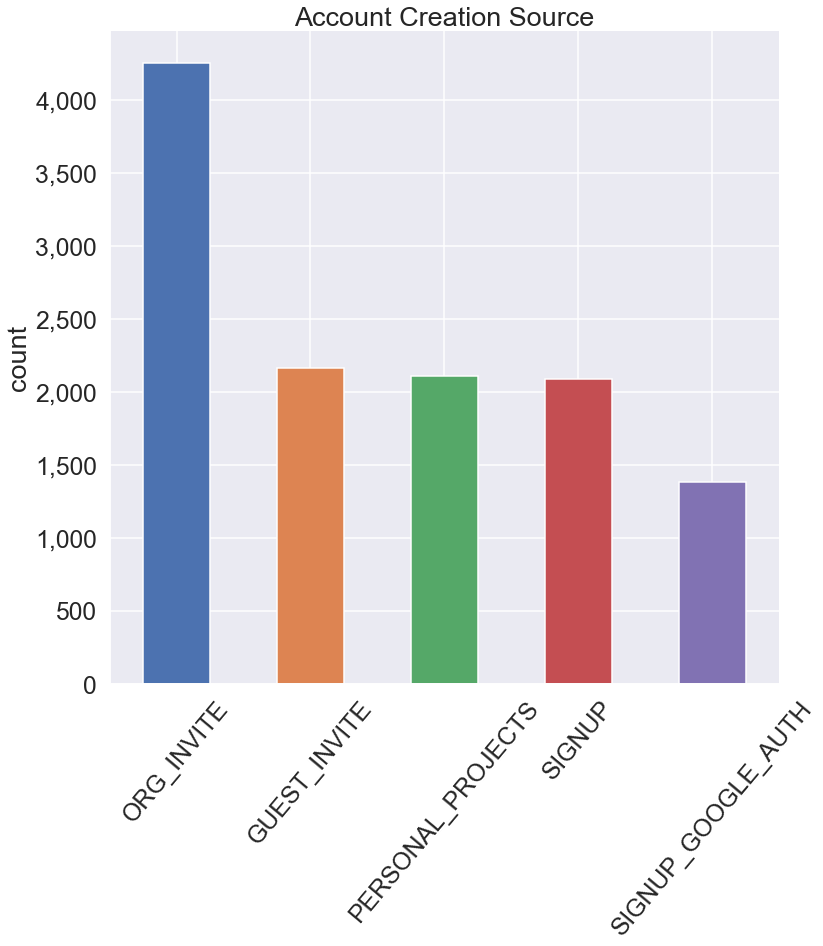

In [14]:
# Plot creation source 

count_plot(df = accounts, col_name = 'creation_source', title = "Account Creation Source")

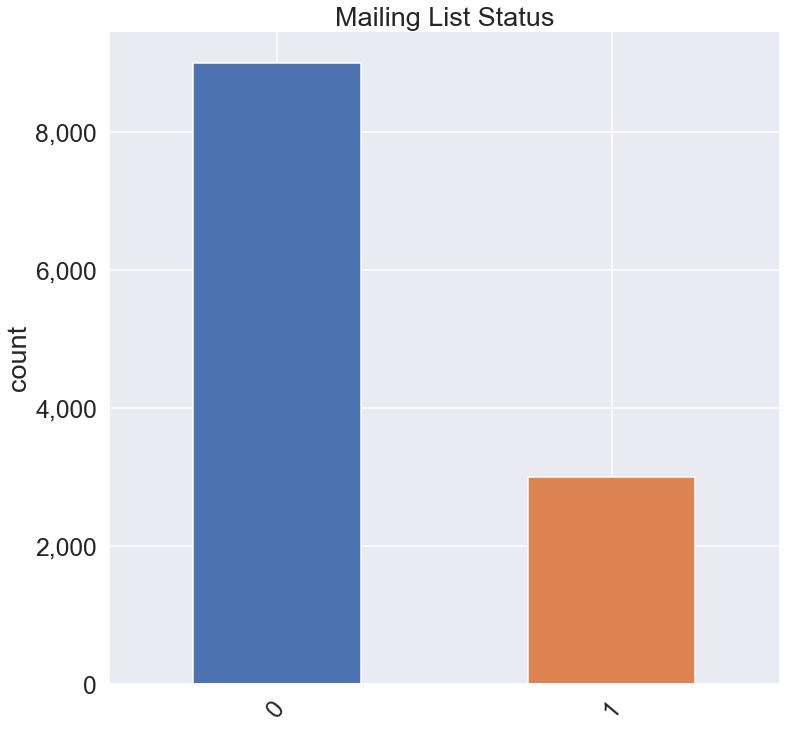

In [15]:
# Plot mailing list source

count_plot(df = accounts, col_name = 'opted_in_to_mailing_list', 
           title = "Mailing List Status")

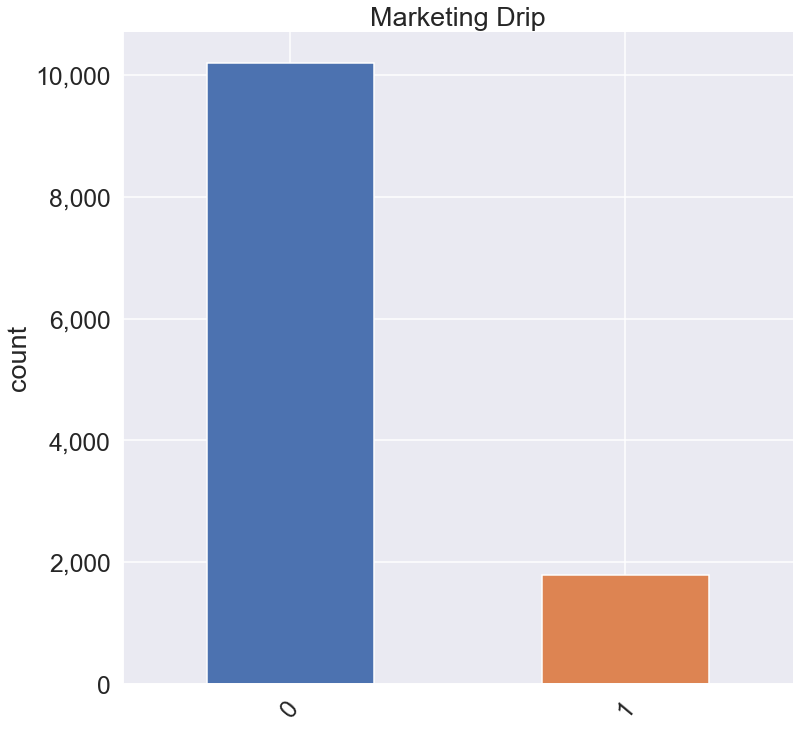

In [16]:
# Plot marketing drip

count_plot(df = accounts, col_name = 'enabled_for_marketing_drip', 
           title = "Marketing Drip")

In [17]:
# Organizations with least and most users

print(pd.DataFrame(accounts.org_id.value_counts()).reset_index().head(10))

print(pd.DataFrame(accounts.org_id.value_counts()).reset_index().tail(10))

   index  org_id
0      0     319
1      1     233
2      2     201
3      3     168
4      4     159
5      6     138
6      5     128
7      9     124
8      7     119
9     10     104
     index  org_id
407    378      10
408    304      10
409    395       9
410    315       9
411    355       9
412    396       9
413    400       8
414    397       8
415    386       7
416    416       2


In [18]:
# Organizations with least and most users

print(pd.DataFrame(accounts.invited_by_user_id.value_counts()).reset_index().head(10))

print(pd.DataFrame(accounts.invited_by_user_id.value_counts()).reset_index().tail(10))

     index  invited_by_user_id
0  10741.0                  13
1   2527.0                  12
2   2308.0                  11
3   1525.0                  11
4  11770.0                  11
5  10628.0                  10
6   7012.0                  10
7   4612.0                  10
8   4803.0                  10
9   1175.0                  10
        index  invited_by_user_id
2554   7916.0                   1
2555   1945.0                   1
2556  11536.0                   1
2557   5989.0                   1
2558  11196.0                   1
2559   2746.0                   1
2560  10456.0                   1
2561   8371.0                   1
2562   6266.0                   1
2563   3572.0                   1


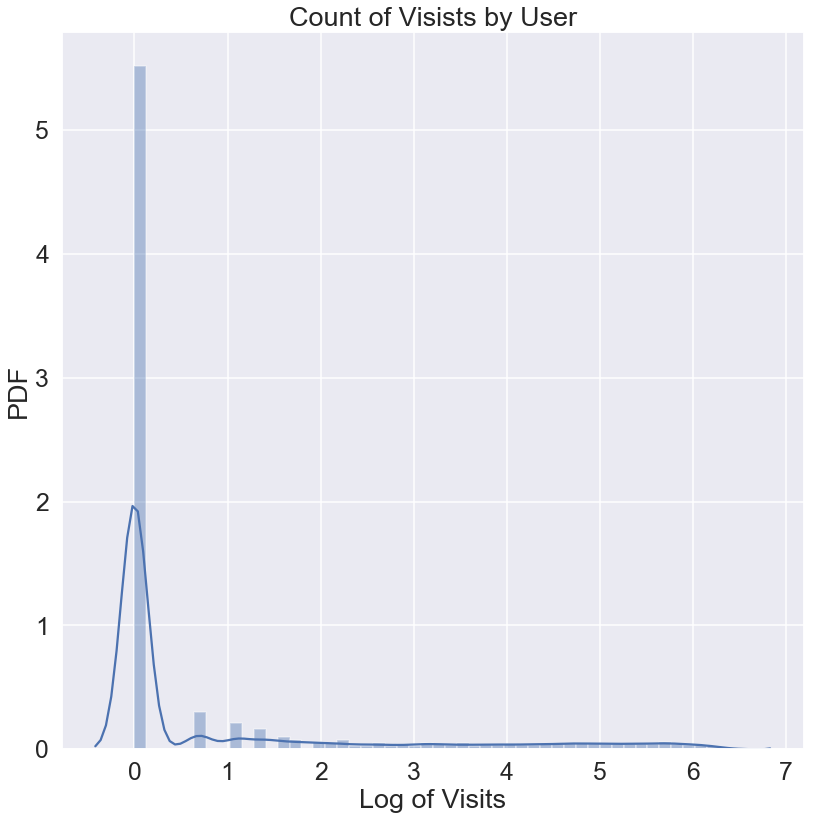

In [19]:
visits_by_user = engagement[['user_id','visited']].groupby('user_id',as_index=False).sum()

sns.distplot(np.log(visits_by_user.visited),norm_hist=True)

plt.ylabel('PDF')

plt.xlabel('Log of Visits')

plt.title('Count of Visists by User')

plt.tight_layout()

### Data Wrangling and Feature Engeeneering

*Create new feature: User is in both drip and mailing list*

In [20]:
# User is in both marketing and mailing list

accounts["drip_list"] = accounts["enabled_for_marketing_drip"]*accounts["opted_in_to_mailing_list"]

In [21]:
driplist_total = len(accounts[accounts["drip_list"]==1])

print('The number users in both total: ',driplist_total,'of',len(accounts), 'total.')

print('Number of users in mktg drip and mailing list are: ', 
      round(driplist_total/len(accounts)*100),'%.')

The number users in both total:  1342 of 12000 total.
Number of users in mktg drip and mailing list are:  11 %.


*Create New Feature: Time Since Last Session*

In [22]:
accounts['time_lastsesh'] = (accounts['last_session_creation_time']-accounts['creation_time']).astype(int)

accounts['time_lastsesh'] = (np.where(accounts['time_lastsesh'] >= 0, accounts['time_lastsesh'], np.nan))

*Create new feature: User is in both drip and mailing list*

In [23]:
# Create indicator variable for invited

accounts['invited_by_user_id'] = accounts['invited_by_user_id'].fillna(0)

accounts['invited_ind'] = np.where(accounts['invited_by_user_id'] == 0, 0, 1)

*Convert Creation Source to Numbers*

In [24]:
# Create dictionary with categories

creation= {'SIGNUP_GOOGLE_AUTH': 1, 'PERSONAL_PROJECTS': 2, 
           'GUEST_INVITE': 3, 'SIGNUP': 4, 'ORG_INVITE': 5}

# Map dictionary to a new column

accounts["creation_source_cat"] = [creation[item] for item in accounts.creation_source]

*Find adopted users*

In [25]:
def adopted(a):
    
    '''Custom aggregation function to find adopted users. An "adopted user" is a user who 
    has logged into the product on three separate days in at least one sevenday period, 
    identify which factors predict future user adoption .'''
    
    if len(a) >= 3:  
        a = [i for i in a]  # convert property object to list
        a.sort()
        # cumulative difference of current and next day
        a = [a[i+1] - a[i] for i in range(len(a)-2)]
        a = [1 for i in range(len(a)-2) if a[i] + a[i+1] + a[i+2] <= timedelta(days=7)]
        if 1 in a:
            return 1

In [26]:
# group by user_id and aggregate using custom function

adopted = engagement.groupby('user_id').agg(adopted)

# fill null values with 0
adopted.fillna(0, inplace=True)  # fill null values with 0
adopted.columns = ['adopted_user']
adopted.head()

,adopted_user
user_id,
1,0.0
2,0.0
3,0.0
4,0.0
5,0.0


In [27]:
adopted_total = len(adopted[adopted['adopted_user']==1])

print('The number of adopted users is',adopted_total,'of',len(adopted), 'total.')

print('Adopted users are: ', round(adopted_total/len(adopted)*100),'%.')

The number of adopted users is 1322 of 8823 total.
Adopted users are:  15 %.


In [28]:
# Merge account information with adoption information

merged = accounts.merge(adopted, how = 'inner', left_on = "object_id", right_on = 'user_id')

#Change adopted from float to int

merged['adopted_user'] = merged['adopted_user'].astype(int)

merged['invited_by_user_id'] = merged['invited_by_user_id'].astype(int)

merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 0 to 8822
Data columns (total 13 columns):
object_id                     8823 non-null int64
creation_time                 8823 non-null datetime64[ns]
creation_source               8823 non-null object
last_session_creation_time    8823 non-null datetime64[ns]
opted_in_to_mailing_list      8823 non-null int64
enabled_for_marketing_drip    8823 non-null int64
org_id                        8823 non-null int64
invited_by_user_id            8823 non-null int64
drip_list                     8823 non-null int64
time_lastsesh                 8823 non-null float64
invited_ind                   8823 non-null int64
creation_source_cat           8823 non-null int64
adopted_user                  8823 non-null int64
dtypes: datetime64[ns](2), float64(1), int64(9), object(1)
memory usage: 965.0+ KB


Text(0.5,1,'Heat Map of Correlations')

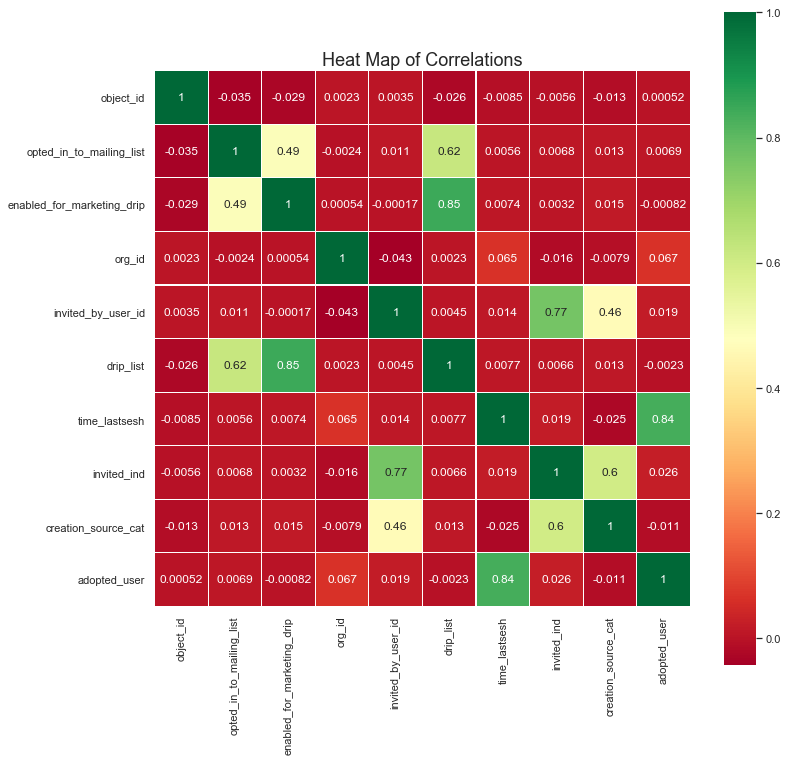

In [29]:
# Make a heatmap of correlations

# Calculate correlations

corr = merged.corr()

sns.set(font_scale=1)

sns.heatmap(corr, square=True, linewidths=.05, annot=True, cmap='RdYlGn')

plt.title('Heat Map of Correlations', fontsize = 18)

### Create train (85%), test (5%) and validation (10% splits)

In [30]:
merged.columns

Index(['object_id', 'creation_time', 'creation_source',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id',
       'drip_list', 'time_lastsesh', 'invited_ind', 'creation_source_cat',
       'adopted_user'],
      dtype='object')

In [31]:
cols = ['object_id', 'creation_time', 'creation_source',
        'last_session_creation_time','adopted_user','time_lastsesh']


x = merged.drop(cols, axis = 1) #drop non-numeric values and y            

y = merged['adopted_user']

In [32]:
# Split the data into a training and test set.
xtrain, xtest, ytrain, ytest = train_test_split(x, y, 
                                                test_size = .15,
                                                train_size = .85, 
                                                random_state=42)

In [33]:
# Split the test set into a validation and test set.
xvalid, xtest, yvalid, ytest = train_test_split(xtest, ytest, 
                                                test_size = .33,
                                                train_size = .67 , 
                                                random_state=42)

**Predictive Modeling:** Logistic Regression

In [34]:
log_model = LogisticRegression()

# Fit the model on the trainning data.

log_model.fit(xtrain, ytrain)

#Predict using testing data
y_predict = log_model.predict(xtest)

# confusion matrix, classification report, and accuracy score
print('Confusion Matrix:')
print(confusion_matrix(ytest, y_predict))
print('CLASSIFICATION REPORT:')
print(classification_report(ytest, y_predict))
print('Accuracy Score: ', accuracy_score(ytest, y_predict))

Confusion Matrix:
[[364   0]
 [ 73   0]]
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91       364
           1       0.00      0.00      0.00        73

   micro avg       0.83      0.83      0.83       437
   macro avg       0.42      0.50      0.45       437
weighted avg       0.69      0.83      0.76       437

Accuracy Score:  0.8329519450800915


/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


**Predictive Modeling:** Decision Tree

In [35]:
tree_model = DecisionTreeClassifier()

# Fit the model on the trainning data.

tree_model.fit(xtrain, ytrain)

#Predict using testing data
y_predict = tree_model.predict(xtest)

# confusion matrix, classification report, and accuracy score
print('Confusion Matrix:')
print(confusion_matrix(ytest, y_predict))
print('CLASSIFICATION REPORT:')
print(classification_report(ytest, y_predict))
print('Accuracy Score: ', accuracy_score(ytest, y_predict))

Confusion Matrix:
[[335  29]
 [ 69   4]]
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.83      0.92      0.87       364
           1       0.12      0.05      0.08        73

   micro avg       0.78      0.78      0.78       437
   macro avg       0.48      0.49      0.47       437
weighted avg       0.71      0.78      0.74       437

Accuracy Score:  0.7757437070938215


### Tuning Parameters of Logistic Regression

*Cross Validation: Check for Overfitting*

In [36]:
scores = cross_val_score(log_model, xvalid, yvalid, cv=5, scoring='accuracy')

scores

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to '

array([0.84269663, 0.84269663, 0.84269663, 0.84180791, 0.84659091])

*Grid Search CV*

In [37]:
#Set parameters to search over

params = {"C": [0.0001, 0.001, 0.1, 1, 10, 100], 
          "penalty": ['l1','l2']}

#Create GridSearch object witk five fold cross validation

models = GridSearchCV(log_model, param_grid=params, cv=5, scoring="accuracy")

models.fit(xvalid, yvalid)

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to '

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to '

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.0001, 0.001, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [38]:
models.best_params_, models.best_score_

({'C': 0.0001, 'penalty': 'l1'}, 0.8432919954904171)

### Final Logistic Regression Model

*Final Model*

In [39]:
log_model_final = LogisticRegression(C = 0.0001, penalty = 'l1')

# Fit the model on the trainning data.

log_model_final.fit(xtrain, ytrain)

#Predict using testing data
y_predict_final = log_model_final.predict(xtest)

# confusion matrix, classification report, and accuracy score
print('Confusion Matrix:')
print(confusion_matrix(ytest, y_predict_final))
print('CLASSIFICATION REPORT:')
print(classification_report(ytest,y_predict_final))
print('Accuracy Score: ', accuracy_score(ytest, y_predict_final))

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Confusion Matrix:
[[364   0]
 [ 73   0]]
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91       364
           1       0.00      0.00      0.00        73

   micro avg       0.83      0.83      0.83       437
   macro avg       0.42      0.50      0.45       437
weighted avg       0.69      0.83      0.76       437

Accuracy Score:  0.8329519450800915


/Applications/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


*Final Model CV*

In [40]:
cvscores = cross_val_score(log_model_final, xvalid, yvalid, cv=5, scoring='accuracy')

print('Average: ',np.average(cvscores), '(+/-)', np.std(cvscores))

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Average:  0.8432977412671756 (+/-) 0.0016821747710394673


/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### Final Logistic Regression Model - Feature Importance

*Relative Feature Importance*

In [41]:
feature_importance = abs(log_model_final.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

*Plot Feature Importances*

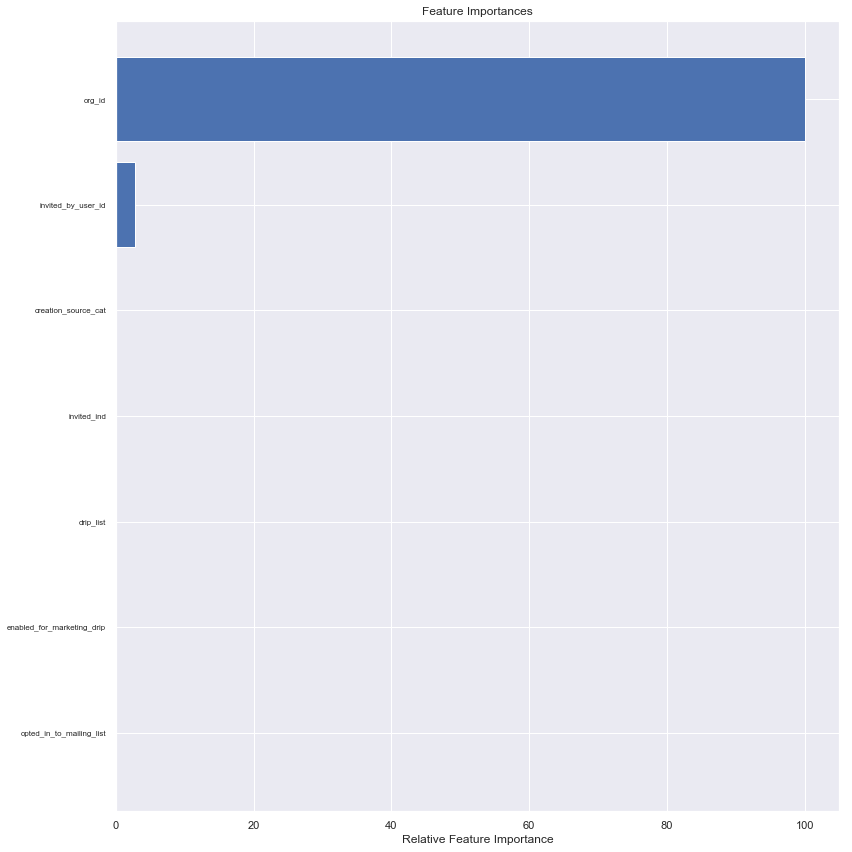

In [42]:
featfig = plt.figure()
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(xtrain.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')
featax.set_title('Feature Importances')

plt.tight_layout()   
plt.show()

## End of Notebook